In [1]:
import pandas as pd
import numpy as np
from scripts import *
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
import seaborn as sns
from scipy import stats
import warnings
from shapely.geometry import Point,Polygon
from sklearn.feature_selection import SelectKBest, f_regression,mutual_info_regression
import geopandas as gpd
from sklearn.preprocessing import PolynomialFeatures
import descartes
from sklearn import metrics
import statsmodels.api as sm
from statsmodels.formula.api import ols
import contextily as ctx
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import cross_val_score
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# importing main data
training_data = pd.read_csv('/Users/brendanferris/Desktop/kings_county_housing/kc_house_data_train.csv')
missing_vals = pd.read_csv('bedroomsfilled.csv')
holdout_data = pd.read_csv('/Users/brendanferris/Desktop/kings_county_housing/kc_house_data_test_features.csv')

training_data.shape, holdout_data.shape

((17290, 22), (4323, 21))

# Baseline Regressor

A baseline regressor will be used to judge our future model's performance. 

In [3]:
y = training_data.price
x = training_data.drop(['price', 'Unnamed: 0', 'date'], axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42, test_size=.2)
x_train.shape, x_test.shape

baseline_lr = LinearRegression()
baseline_lr.fit(x_train, y_train)
y_hat = baseline_lr.predict(x_test)
MSE = mean_squared_error(y_test, y_hat)
print('Baseline RMSE:',np.sqrt(MSE).round(5))

Baseline RMSE: 198822.52762


# Housing Prices: first look.

In [4]:
len_ten_percent = int(len(training_data)*.10)
average_top_prices = np.mean(training_data.price.sort_values(ascending=False)[:len_ten_percent])
average_lower_prices = np.mean(training_data.price.sort_values()[:len_ten_percent])

print("The highest 10% of houses are priced above ${}, while the lowest 10% are priced below ${}".format(int(average_top_prices), int(average_lower_prices)))

The highest 10% of houses are priced above $1350116, while the lowest 10% are priced below $203451


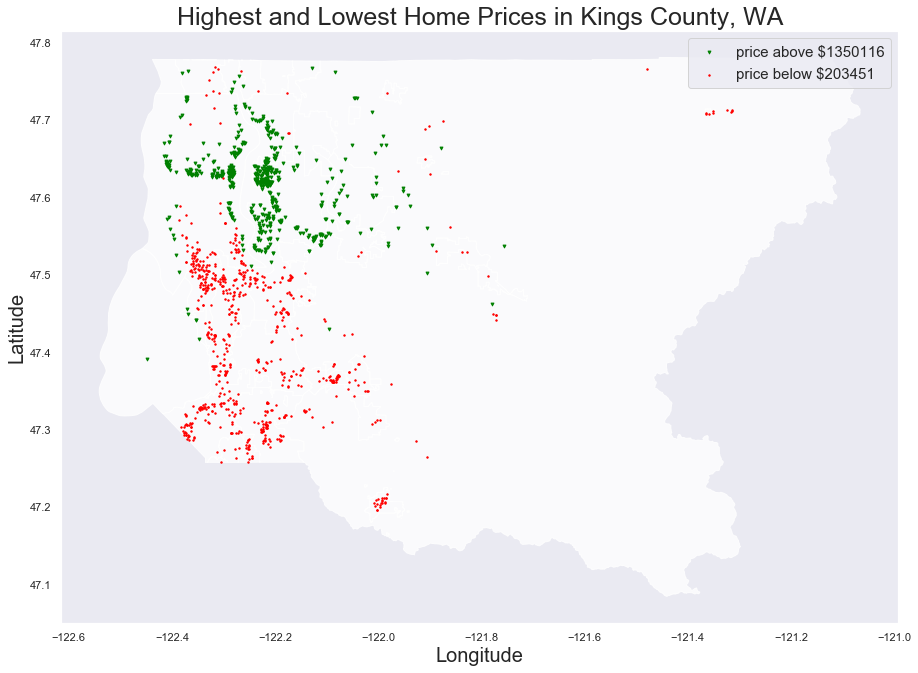

In [47]:
king_map = gpd.read_file('/Users/brendanferris/Desktop/kings_county_housing/EDA/Cities_and_Unincorporated_King_County___city_kc_area-shp')
geometry = [Point(x,y) for x,y in zip(training_data['long'], training_data['lat'])]
fig, ax = plt.subplots(figsize = (15,15))
king_map.plot(ax=ax, alpha = 0.8, color = 'white', aspect='auto')
geo_df = gpd.GeoDataFrame(training_data,  
                          geometry = geometry)

geo_df[geo_df['price'] > average_top_prices].plot(ax = ax , markersize = 8,
                                                  color = 'green', marker = 'v',
                                                  aspect = 1.5, label="price above ${}".format(int(average_top_prices)))
geo_df[geo_df['price'] < average_lower_prices].plot(ax = ax , markersize = 8,
                                                    color = 'red',marker = '.',
                                                    aspect = 1.5, label = "price below ${}".format(int(average_lower_prices)))

ax.set_title('Highest and Lowest Home Prices in Kings County, WA', fontdict =
             {'fontsize': 25})

ax.set_ylabel('Latitude',fontdict = {'fontsize': 20})
ax.set_xlabel('Longitude',fontdict = {'fontsize': 20})
plt.legend(prop={"size":15});

#remove geometry no longer needed
training_data.drop(['geometry'], axis=1, inplace=True)

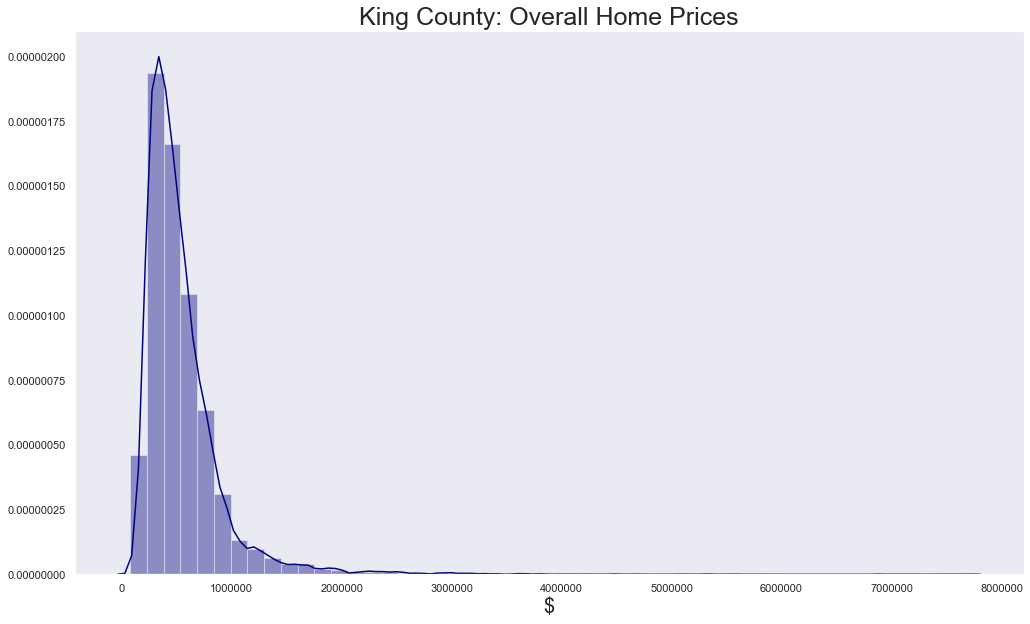

In [6]:
sns.set(rc={'figure.figsize':(17,10)})
sns.set_style('dark')
sns.distplot(training_data['price'], color='navy')

plt.xlabel("$", fontsize= 20)
plt.title("King County: Overall Home Prices", fontsize= 25);

# Remove outliers

In [7]:
## add code here and apply to train and test set

In [9]:
clean_beds(training_data)
clean_beds(holdout_data)

Entries with an abnormal amount of bedrooms have been replaced with 3.0, the median number of bedrooms in the dataframe. 

Entries with an abnormal amount of bedrooms have been replaced with 3.0, the median number of bedrooms in the dataframe. 



In [ ]:
fig, ax = plt.subplots(figsize = (8,5))
ax = sns.boxplot(x=training_data["bedrooms"])
ax.set_title('Outlier bedrooms', fontdict =
             {'fontsize': 25});

# Adding Additional Zipcode Information

Additional zipcode information was collected from [here](https://www.unitedstateszipcodes.org) to allow for additional relevant features. The information is added to every row with matching zipcodes. 

In [10]:
# import additional zipcode data
zipcode_data = pd.read_excel('/Users/brendanferris/Desktop/kings_county_housing/EDA/extradata.xlsx', index_col='zipcode')
clean_data(training_data)
clean_data(missing_vals)
clean_data(holdout_data)

#replaced missing values with correct info from zillow.
#training_data = no_bedrooms(training_data, missing_vals)

#merge the original data with additional zipcode data. 
training_data = pd.merge(training_data, zipcode_data, how='right', on='zipcode')
holdout_data = pd.merge(holdout_data, zipcode_data, how='right', on='zipcode')

# Asking Questions and Performing Statistical Tests

#### Do areas that have more home renters have higher home prices?

H0 : The median number of home renters in an Kings County does not has an effect on the house prices in the area. 


Ha : The median number of home renters in Kings County has an effect on the house prices in the area. 

In [11]:
# First, we need the median number of seasonal properties in all of the zip codes.

median_rentals = np.median(training_data.renter_occupied_households)

print('The median number of rented homes in Kings County is: {}'.format(int(median_rentals)))

The median number of rented homes in Kings County is: 4007


In [12]:
more_renters = training_data.loc[training_data['renter_occupied_households'] >= 4007]
less_renters = training_data.loc[training_data['renter_occupied_households'] < 4007]

res = stats.ttest_ind(more_renters.price,less_renters.price, equal_var = False)

print('At an alpha of .05, we reject the null hypothesis with a p-value of {}\n'.format(res[1].round(3)))
print('The median number of home renters in Kings County does have an significant effect on housing prices in that area.')

At an alpha of .05, we reject the null hypothesis with a p-value of 0.002

The median number of home renters in Kings County does have an significant effect on housing prices in that area.


#### Do houses built in the past after 2005 fetch higher prices than older houses?

H0: There is no significant difference between the age of a house and the price of the house.

Ha: There is a significant difference between the age of a house and the price of the house.  

*Generating a new feature "home_age" which is the year the home was built minus 2015 (most recent data in the dataset).* 

In [13]:
training_data['home_age'] =  2015 - training_data.yr_built
holdout_data['home_age'] = 2015 - holdout_data.yr_built

decade_old = training_data.loc[training_data['home_age'] <= 10]
older_than_ten_years = training_data.loc[training_data['home_age'] > 10]

res = stats.ttest_ind(decade_old.price,older_than_ten_years.price, equal_var = False)


print('At an alpha of .05, we accept the null hypothesis with a p-value of {}\n'.format(res[1].round(3)))
print('The age of a house has does have a significant effect on the price of the house. \n')
print("Due the it's significance with the target variable(price), we will add home age to our model")

At an alpha of .05, we accept the null hypothesis with a p-value of 0.0

The age of a house has does have a significant effect on the price of the house. 

Due the it's significance with the target variable(price), we will add home age to our model


#### Do the amount of available homes in an area have an effect on the price of the homes in that area?

H0: Areas with lower than average home availability has no effect on the prices of homes in that area.

Ha: Areas with lower than average home availability has an effect on the prices of homes in that area.

*Generating a new feature "available housing" which is the total number of total housing units minus the occupied housing units in a particular zipcode.* 

In [14]:
training_data['available_housing'] = training_data['total_housing_units'] - training_data['occupied_housing_units']
holdout_data['available_housing'] = holdout_data['total_housing_units'] - holdout_data['occupied_housing_units']

In [15]:
# First, we need the median number of available homes in all of the zip codes.

mean_available_housing = np.median(training_data.available_housing)

print('The median number of available homes in King County are {}'.format(int(mean_available_housing)))

The median number of available homes in King County are 741


In [16]:
few_available_homes = training_data.loc[training_data['available_housing'] <= 741]
many_available_homes = training_data.loc[training_data['available_housing'] > 741]

res = stats.ttest_ind(few_available_homes.price,many_available_homes.price, equal_var = False)

print('At an alpha of .05, we reject the null hypothesis with a p-value of {}\n'.format(res[1]))
print('The median number of available homes in an area has a significant effect on the housing prices in those area. \n')
print("Due the it's significance with the target variable(price), we will add available housing to our model")

At an alpha of .05, we reject the null hypothesis with a p-value of 2.1968467841663284e-13

The median number of available homes in an area has a significant effect on the housing prices in those area. 

Due the it's significance with the target variable(price), we will add available housing to our model


In [17]:
training_data.shape, holdout_data.shape

((17290, 38), (4323, 37))

# Min/Max Scaling

In [18]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaled_feat = ['pop_density',
               'sqft_living15', 
               'sqft_above', 
               'sqft_basement',
               'bedrooms',
               'bathrooms',
               'median_household_income',
               'median_home_value',
               'sqft_lot']


training_data[scaled_feat] = scaler.fit_transform(training_data[scaled_feat])  
holdout_data[scaled_feat] = scaler.fit_transform(holdout_data[scaled_feat])

# Creating Dummies For Categorical Variables

In [19]:
# dummies for the training data
waterfront_dummies = pd.get_dummies(training_data['waterfront'], prefix='waterf', drop_first=True)
view_dummies = pd.get_dummies(training_data['view'], prefix='has_view', drop_first=True)
condition_dummies = pd.get_dummies(training_data['condition'], prefix='condition', drop_first=True)
grade_dummies = pd.get_dummies(training_data['grade'], prefix='grade', drop_first=True)
month_dummies = pd.get_dummies(training_data['sale_month'], prefix='month', drop_first=True)
zip_dummies = pd.get_dummies(training_data['zipcode'], prefix='zip', drop_first=True)

# dummies for the holdout set
waterfront_dummies_1 = pd.get_dummies(holdout_data['waterfront'], prefix='waterf', drop_first=True)
view_dummies_1 = pd.get_dummies(holdout_data['view'], prefix='has_view', drop_first=True)
condition_dummies_1 = pd.get_dummies(holdout_data['condition'], prefix='condition', drop_first=True)
grade_dummies_1 = pd.get_dummies(holdout_data['grade'], prefix='grade', drop_first=True)
month_dummies_1 = pd.get_dummies(holdout_data['sale_month'], prefix='month', drop_first=True)
zip_dummies_1 = pd.get_dummies(holdout_data['zipcode'], prefix='zip', drop_first=True)

# dropping original categories for the training data
training_data = training_data.drop(['postoffice','id','zipcode','sale_month','waterfront', 'view', 'condition', 'grade'], axis=1)
training_data = pd.concat([training_data, waterfront_dummies, view_dummies, condition_dummies, grade_dummies, month_dummies, zip_dummies], axis=1)

# dropping original categories for the holdout data
holdout_data = holdout_data.drop(['postoffice','id','zipcode','sale_month','waterfront', 'view', 'condition', 'grade'], axis=1)
holdout_data = pd.concat([holdout_data, waterfront_dummies_1, view_dummies_1, condition_dummies_1, grade_dummies_1, month_dummies_1, zip_dummies_1], axis=1)
training_data.shape, holdout_data.shape

((17290, 130), (4323, 128))

# Removing Colinear Features

In [20]:
# for the training set
training_data.drop(['zip_98003',
                    'owned_household_with_mortgage', 
                    'houses_owned_outright',
                    'land_area',
                    'occupied_housing_units',
                    'total_housing_units',
                    'sqft_living', 
                    'condition_3'], axis=1, inplace=True)
# for the holdout set
holdout_data.drop(['zip_98003',
                    'owned_household_with_mortgage', 
                    'houses_owned_outright',
                    'land_area',
                    'occupied_housing_units',
                    'total_housing_units',
                    'sqft_living', 
                    'condition_3'], axis=1, inplace=True)

In [21]:
multicolinear_features(training_data) #graph should be empty

,cc
pairs,


# Sklearn Linear Model

In [22]:
#training_data.fillna('0', inplace=True)

y = training_data.price
x = training_data.drop(['price'], axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42, test_size=.2)
x_train.shape, x_test.shape

((13832, 121), (3458, 121))

In [23]:
lr_1 = LinearRegression()
lr_1.fit(x_train, y_train)
y_hat = lr_1.predict(x_test)
MSE = mean_squared_error(y_test, y_hat)
print('RMSE',np.sqrt(MSE).round(5))

RMSE 140476.59608


In [24]:
np.mean(cross_val_score(estimator=lr_1, X=x_train, y=y_train, cv=5))

training_data

,price,bedrooms,bathrooms,sqft_lot,floors,sqft_above,sqft_basement,yr_built,yr_renovated,lat,...,zip_98146,zip_98148,zip_98155,zip_98166,zip_98168,zip_98177,zip_98178,zip_98188,zip_98198,zip_98199
0,365000.0,0.4,0.28125,0.005041,2.0,0.195175,0.000000,1986,0,47.4388,...,0,0,0,0,0,0,0,0,0,0
1,455000.0,0.4,0.21875,0.056914,1.0,0.105263,0.165975,1959,0,47.4492,...,0,0,0,0,0,0,0,0,0,0
2,273000.0,0.3,0.21875,0.005133,2.0,0.192982,0.000000,1959,0,47.4572,...,0,0,0,0,0,0,0,0,0,0
3,223000.0,0.2,0.12500,0.005632,1.0,0.067982,0.000000,1957,0,47.4572,...,0,0,0,0,0,0,0,0,0,0
4,335500.0,0.5,0.37500,0.011218,1.0,0.154605,0.112033,1968,0,47.4416,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17285,1950000.0,0.4,0.46875,0.010208,1.0,0.311404,0.211618,1963,2000,47.6390,...,0,0,0,0,0,0,0,0,0,0
17286,2450000.0,0.7,0.53125,0.013656,2.0,0.480263,0.000000,1992,0,47.6183,...,0,0,0,0,0,0,0,0,0,0
17287,2100000.0,0.4,0.21875,0.011687,2.0,0.357456,0.000000,1962,2002,47.6236,...,0,0,0,0,0,0,0,0,0,0
17288,1620000.0,0.4,0.28125,0.010381,2.0,0.225877,0.000000,1977,0,47.6232,...,0,0,0,0,0,0,0,0,0,0


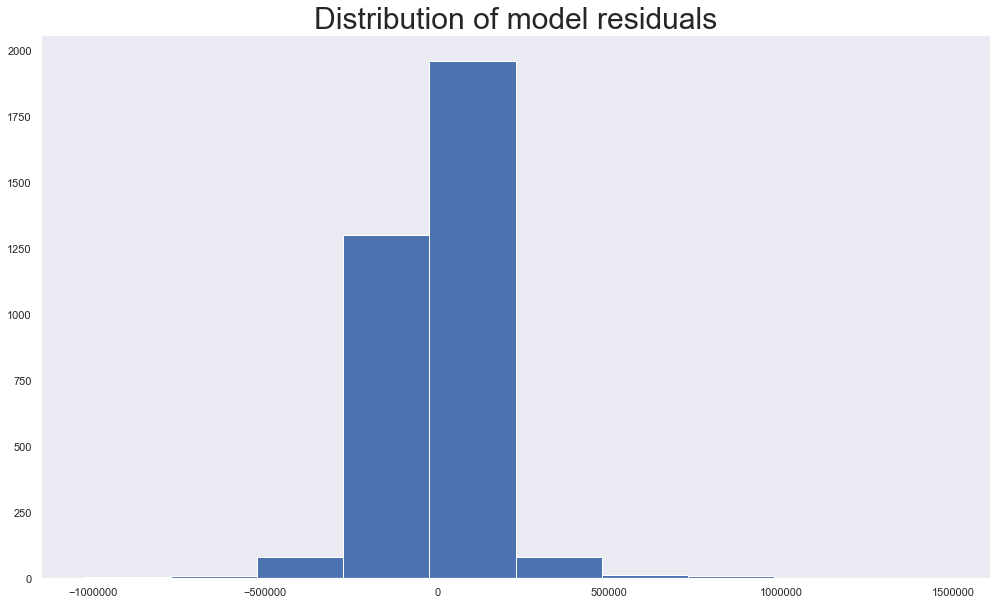

In [25]:
residuals = (y_test - y_hat)
plt.hist(residuals);
plt.title('Distribution of model residuals', size=30);

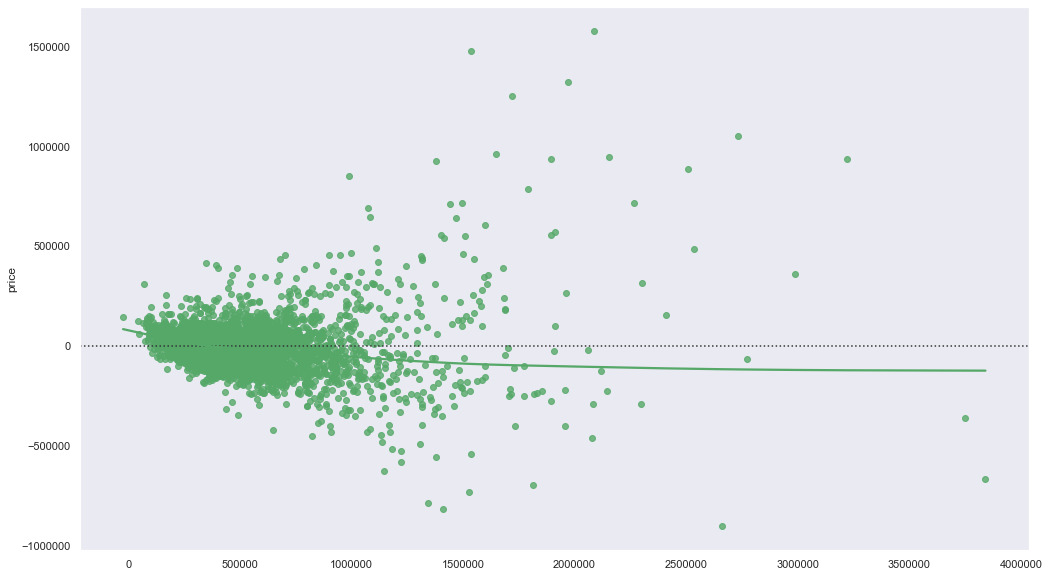

In [26]:
sns.residplot(y_hat, y_test, lowess=True, color='g');

# OLS Linear Model

In [27]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

outcome = 'price'
predictors = training_data.drop('price', axis=1)
pred_sum = "+".join(predictors.columns)
formula = outcome + "~" + pred_sum


model = ols(formula= formula, data=training_data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     791.3
Date:                Thu, 22 Oct 2020   Prob (F-statistic):               0.00
Time:                        21:36:42   Log-Likelihood:            -2.3065e+05
No. Observations:               17290   AIC:                         4.615e+05
Df Residuals:                   17177   BIC:                         4.624e+05
Df Model:                         112                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                    -78.3557      8.371     -9.360      0.000     -94.764     -61.947
bedrooms                    -1.32e+05   1.71e+04     -7.724      0.000   -1.65e+05   -9.85e+04
bathrooms                   1.985e+05   2.22e+04      8.945      0.000    1.55e+05    2.42e+05
sqft_lot                    3.402e+05   6.38e+04      5.329      0.000    2.15e+05    4.65e+05
floors                     -2.939e+04   3355.540     -8.758      0.000    -3.6e+04   -2.28e+04
sqft_above                  1.535e+06   3.03e+04     50.651      0.000    1.48e+06    1.59e+06
sqft_basement               5.525e+05    1.8e+04     30.644      0.000    5.17e+05    5.88e+05
yr_built                   -7.907e+04   8433.190     -9.376      0.000   -9.56e+04   -6.25e+04
yr_renovated                  28.5569      3.125      9.137      0.000      22.431      34.683
lat                         2.268e+05   6.64e+04      3.417      0.001    9.67e+04    3.57e+05
long                       -2.178e+05   4.73e+04     -4.601      0.000   -3.11e+05   -1.25e+05
sqft_living15               1.002e+05   1.78e+04      5.620      0.000    6.52e+04    1.35e+05
sqft_lot15                    -0.0555      0.062     -0.889      0.374      -0.178       0.067
sale_year                   6.052e+04   7852.630      7.707      0.000    4.51e+04    7.59e+04
population                    -4.4585      0.948     -4.704      0.000      -6.316      -2.601
pop_density                 8.234e+04   1.62e+04      5.077      0.000    5.05e+04    1.14e+05
median_household_income      2.11e+05   1.89e+04     11.142      0.000    1.74e+05    2.48e+05
median_home_value           4.101e+05   1.26e+04     32.560      0.000    3.85e+05    4.35e+05
water_area_sq_mile          -359.1524   1434.223     -0.250      0.802   -3170.376    2452.071
renter_occupied_households    19.9764      3.506      5.697      0.000      13.104      26.849
sold_and_unoccupied          928.1820    385.789      2.406      0.016     171.995    1684.369
seasonal_or_rec_use            2.7798     37.278      0.075      0.941     -70.288      75.848
home_age                   -7.881e+04   8434.829     -9.344      0.000   -9.53e+04   -6.23e+04
available_housing             -0.6579      0.186     -3.537      0.000      -1.023      -0.293
waterf_1                    5.774e+05   1.64e+04     35.206      0.000    5.45e+05     6.1e+05
has_view_1                  7.831e+04   9616.688      8.143      0.000    5.95e+04    9.72e+04
has_view_2                  7.142e+04   5832.386     12.245      0.000       6e+04    8.29e+04
has_view_3                  1.388e+05   8012.716     17.318      0.000    1.23e+05    1.54e+05
has_view_4                  2.901e+05    1.2e+04     24.200      0.000    2.67e+05    3.14e+05
condition_2                -6804.6162   1.3

# Adding Polynomial Features

In [28]:
poly_feats = PolynomialFeatures(degree=2, include_bias=False)
poly_data = poly_feats.fit_transform(training_data.drop(columns='price', axis=1))
poly_columns = poly_feats.get_feature_names(training_data.columns.drop('price'))
df_poly = pd.DataFrame(poly_data, columns=poly_columns)
df_poly.head()

,bedrooms,bathrooms,sqft_lot,floors,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,...,zip_98178^2,zip_98178 zip_98188,zip_98178 zip_98198,zip_98178 zip_98199,zip_98188^2,zip_98188 zip_98198,zip_98188 zip_98199,zip_98198^2,zip_98198 zip_98199,zip_98199^2
0,0.4,0.28125,0.005041,2.0,0.195175,0.000000,1986.0,0.0,47.4388,-122.162,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.4,0.21875,0.056914,1.0,0.105263,0.165975,1959.0,0.0,47.4492,-122.084,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.3,0.21875,0.005133,2.0,0.192982,0.000000,1959.0,0.0,47.4572,-122.180,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.2,0.12500,0.005632,1.0,0.067982,0.000000,1957.0,0.0,47.4572,-122.184,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.5,0.37500,0.011218,1.0,0.154605,0.112033,1968.0,0.0,47.4416,-122.149,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
y = pd.read_csv('y.csv')
y.head(2) # put prices into its own file.

,price
0,365000.0
1,455000.0


# Creating Polynomial Features and Selecting Relevant Features to improve RMSE

In [31]:
y_poly = y.price
x_poly = df_poly

x_train, x_test, y_train, y_test = train_test_split(x_poly, y, random_state=42, test_size=.2)
x_train.shape, x_test.shape

((13832, 7502), (3458, 7502))

In [32]:
lr_poly = LinearRegression()
lr_poly.fit(x_train, y_train)
y_hat = lr_poly.predict(x_test)
MSE = mean_squared_error(y_test, y_hat)
print('RMSE',np.sqrt(MSE).round(5))

RMSE 4380640.43444


# Selecting the Best Polynomial Features.

In [34]:
selector = SelectKBest(f_regression, k=250)

selector.fit(x_train, y_train)

SelectKBest(k=250, score_func=<function f_regression at 0x7fdd2d90da60>)

In [35]:
selected_columns = x_train.columns[selector.get_support()]
removed_columns = x_train.columns[~selector.get_support()]

In [36]:
#instantiate
lm_kbest = LinearRegression()

#fit
lm_kbest = lm_kbest.fit(x_train[selected_columns], y_train)

y_train_kbest = lm_kbest.predict(x_train[selected_columns])


trainK_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_kbest))


print('Training Root Mean Squared Error:' , trainK_rmse)

y_kbest = lm_kbest.predict(x_test[selected_columns])

testK_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_kbest))

print('Testing Root Mean Squared Error:' , testK_rmse)

Training Root Mean Squared Error: 120201.92243539216
Testing Root Mean Squared Error: 122664.60147225358


In [37]:
scrap = list(removed_columns) #list of the worst performing columns.

In [38]:
x_poly.drop(scrap, axis=1, inplace=True) # drop the worst performing features. 
x_poly.shape

(17290, 250)

# Final Model.

In [39]:
y_poly = y.price
x_poly = df_poly

x_train, x_test, y_train, y_test = train_test_split(x_poly, y, random_state=42, test_size=.2)
x_train.shape, x_test.shape

((13832, 250), (3458, 250))

In [40]:
lr_poly = LinearRegression()
lr_poly.fit(x_train, y_train)
y_hat = lr_poly.predict(x_test)
MSE = mean_squared_error(y_test, y_hat)
print('RMSE',np.sqrt(MSE).round(5))

RMSE 122664.60147


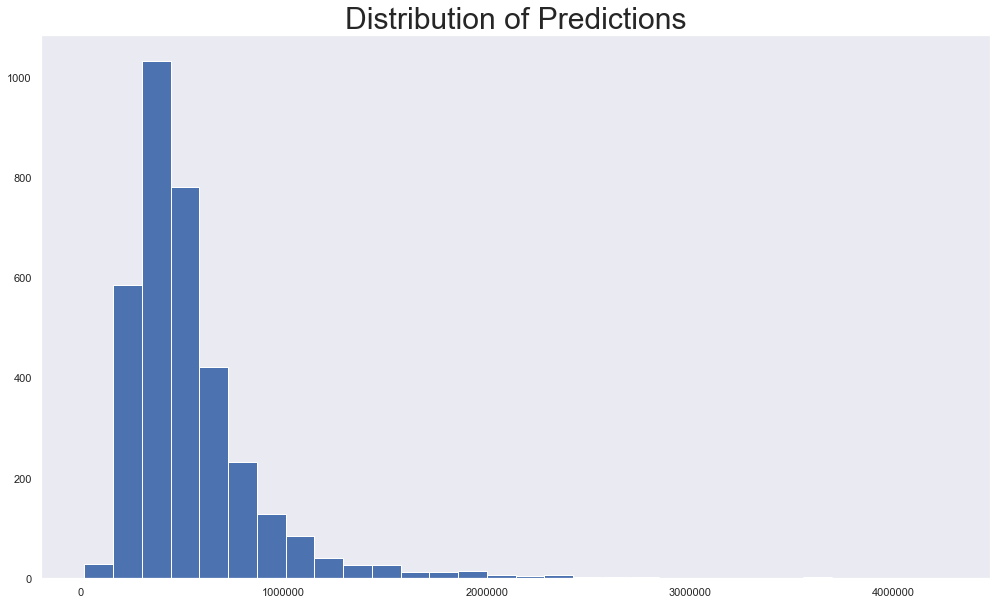

In [41]:
plt.hist(y_hat, bins=30);
plt.title('Distribution of Predictions', size=30);

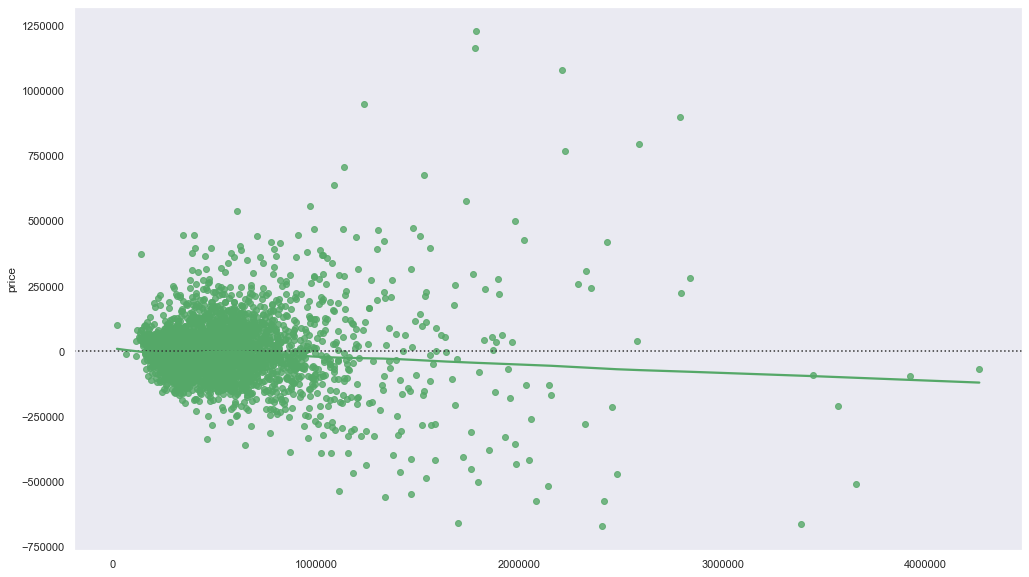

In [42]:
sns.residplot(y_hat, y_test, lowess=True, color='g');

# Testing on the holdout set

In [44]:
holdout_data['grade_3'] = 0 # missing from the holdout so we need to add.

In [45]:
lr_1.predict(holdout_data)


array([ 637560.71350107, 2488055.1573396 , 1092521.4044466 , ...,
       1273833.5884895 ,  993999.97967988, 1368114.24976134])

In [46]:
holdout_data.shape

(4323, 121)

# Pickling the final model.